# Feedback Prize - ELL - Bag-of-words TensorFlow Starter

Hi, everyone! This notebook is a basic bag-of-words solution. It covers:
* Basic EDA
* Bag of words vectorization with TensorFlow
* A simple neural network
* Submission

EDA parts are inspired by [Lex's great notebook](https://www.kaggle.com/code/lextoumbourou/feedback3-eda-hf-custom-trainer-sift/notebook). Please check it as well.

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(f'TF version: {tf.__version__}')

TF version: 2.6.4


In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)

# Load DataFrame

In [3]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
display(df.head())
print('\n---------DataFrame Summary---------')
df.info()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5



---------DataFrame Summary---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


# Data split

So "full text" is our input data. We want to predict scores of "cohesion", "syntax", "vocabulary", "phraseology", "grammar" and "conventions".


Let's define the target columns and count text words for later use. Then, we random split training data.

In [4]:
TARGET_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

df['word_count'] = df['full_text'].apply(lambda x: len(x.split()))

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
print(f'Training examples: {len(train_df)}, validation examples: {len(val_df)}')

Training examples: 3519, validation examples: 392


Defining plot functions to check distributions.

In [5]:
def plot_word_count(df):
    fig = plt.figure(figsize=(15, 5))
    sns.histplot(data=df, x="word_count")
    plt.show()
    
def plot_target_hist(df):
    fig, axes = plt.subplots(1, len(TARGET_COLS), sharey='row', figsize=(18, 3))

    for i, target_col in enumerate(TARGET_COLS):
        ax = axes.flat[i]
        sns.histplot(x=target_col, data=df, ax=ax, linewidth=1.25, alpha=1, zorder=2)
        ax.set_title(target_col)
        ax.set(xlabel=None, ylabel=None)
    plt.tight_layout()
    plt.show()

After splitting, we see word counts distribution of training dataset and validation dataset are roughly the same.


			Whole dataset text word count histogram


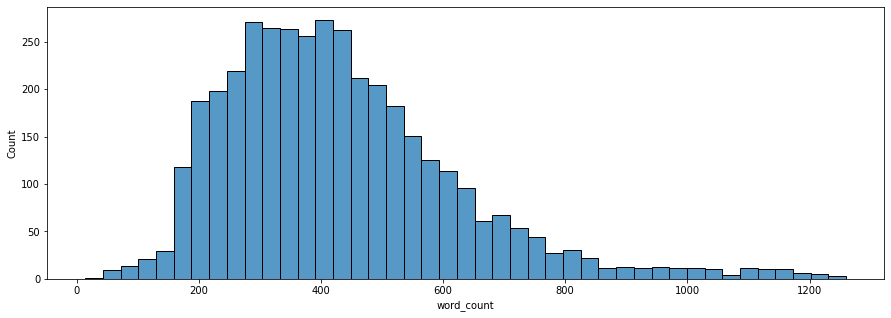


			Training dataset text word count histogram


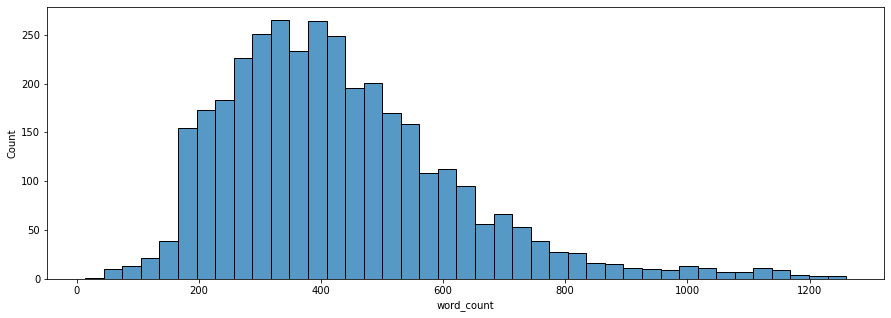


			Validation dataset text word count histogram


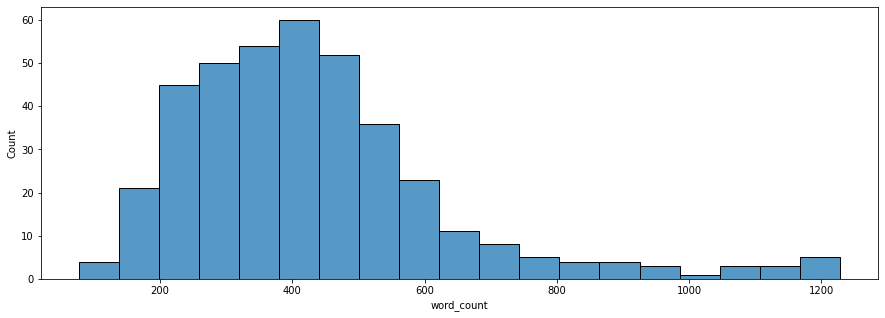

In [6]:
print('\n\t\t\tWhole dataset text word count histogram')
plot_word_count(df)
print('\n\t\t\tTraining dataset text word count histogram')
plot_word_count(train_df)
print('\n\t\t\tValidation dataset text word count histogram')
plot_word_count(val_df)

Targets distributions also stay roughly the same.


			Whole dataset targets distribution


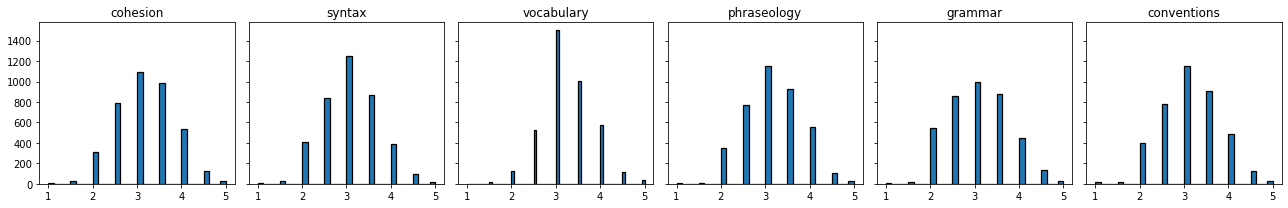


			Training dataset targets distribution


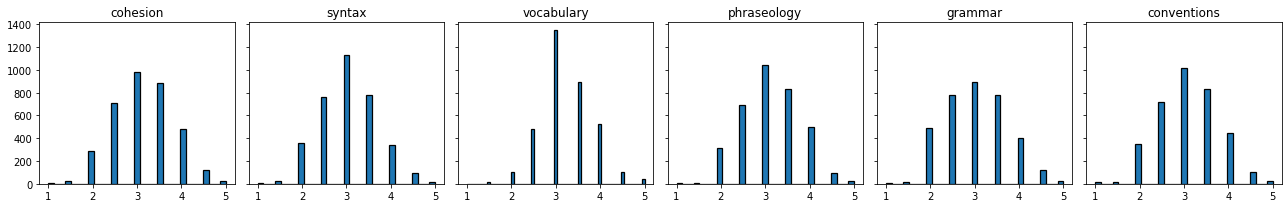


			Validation dataset targets distribution


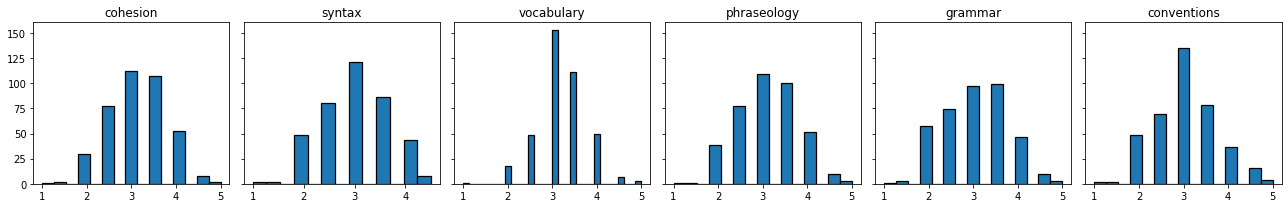

In [7]:
print('\n\t\t\tWhole dataset targets distribution')
plot_target_hist(df)
print('\n\t\t\tTraining dataset targets distribution')
plot_target_hist(train_df)
print('\n\t\t\tValidation dataset targets distribution')
plot_target_hist(val_df)

# Data preprocessing

Create tf dataset from DataFrame. Check a few examples.

In [8]:
def load_dataset(df):
    text = df['full_text']
    targets = df[TARGET_COLS]
    return tf.data.Dataset.from_tensor_slices((text, targets))

raw_ds = load_dataset(df)

for text, targets in raw_ds.take(3):
    print(text)
    print(targets, '\n')

tf.Tensor(b"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear.\n\nmost students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set 

2022-10-05 08:22:56.676100: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Bag-of-words

To use bag-of-words approach, we can utilize TensorFlow TextVectorization layer. Here we use 4-grams bag-of-words, meaning we will include at most four consecutive words appear in the whole text as a token to give our model a bit of local order information, and we vectorize text in multi-hot form. After adapting the whole text, we check out our vocabulary.

In [9]:
MAX_TOKENS = 50000
bag_vectorization = tf.keras.layers.TextVectorization(
    ngrams=4,
    max_tokens=MAX_TOKENS, 
    output_mode="multi_hot",
)
text_only_ds = raw_ds.map(lambda x, y: x)
bag_vectorization.adapt(text_only_ds)
print(f'\nThe first 100 tokens in this vocabulary: {bag_vectorization.get_vocabulary()[:100]}\n')
print(f'\nThe last 100 tokens in this vocabulary: {bag_vectorization.get_vocabulary()[-100:]}\n')

2022-10-05 08:22:57.926544: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



The first 100 tokens in this vocabulary: ['[UNK]', 'to', 'the', 'and', 'you', 'a', 'that', 'in', 'they', 'is', 'i', 'of', 'have', 'for', 'be', 'it', 'can', 'because', 'people', 'are', 'not', 'do', 'students', 'school', 'or', 'with', 'if', 'we', 'your', 'will', 'their', 'more', 'my', 'what', 'but', 'time', 'good', 'on', 'get', 'work', 'like', 'when', 'some', 'this', 'want', 'them', 'life', 'help', 'would', 'make', 'at', 'so', 'dont', 'about', 'to be', 'think', 'all', 'to do', 'one', 'from', 'there', 'in the', 'how', 'also', 'other', 'was', 'something', 'he', 'want to', 'know', 'need', 'should', 'things', 'going', 'me', 'better', 'just', 'by', 'go', 'person', 'have to', 'as', 'you can', 'example', 'take', 'always', 'our', 'if you', 'doing', 'its', 'student', 'learn', 'way', 'up', 'have a', 'many', 'who', 'of the', 'going to', 'a good']


The last 100 tokens in this vocabulary: ['make this world', 'make the school', 'make the person', 'make other people', 'make money for', 'make mistake'

Then we continue to set up our preprocessing pipeline.

In [10]:
BUFFER_SIZE = len(train_df)
BATCH_SIZE = 8
AUTO = tf.data.experimental.AUTOTUNE

def get_train_ds():
    ds = load_dataset(train_df)
    ds = ds.map(lambda x, y: (bag_vectorization(x), tf.cast(y, tf.float32)), num_parallel_calls=AUTO)
    ds = ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
    return ds

def get_val_ds():
    ds = load_dataset(val_df)
    ds = ds.map(lambda x, y: (bag_vectorization(x), tf.cast(y, tf.float32)), num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

In [11]:
train_ds = get_train_ds()
val_ds = get_val_ds()

for inputs, targets in train_ds.take(1):
    print(f'Training inputs shape: {inputs.shape}')
    print(f'Training inputs dtype: {inputs.dtype}')
    print(f'Training targets shape: {targets.shape}')
    print(f'Training targets dtype: {targets.dtype}')
    
for inputs, targets in val_ds.take(1):
    print(f'Validation inputs shape: {inputs.shape}')
    print(f'Validation inputs dtype: {inputs.dtype}')
    print(f'Validation targets shape: {targets.shape}')
    print(f'Validation targets dtype: {targets.dtype}')

Training inputs shape: (8, 50000)
Training inputs dtype: <dtype: 'float32'>
Training targets shape: (8, 6)
Training targets dtype: <dtype: 'float32'>
Validation inputs shape: (8, 50000)
Validation inputs dtype: <dtype: 'float32'>
Validation targets shape: (8, 6)
Validation targets dtype: <dtype: 'float32'>


# Model

Define a simple neural network.

In [12]:
def get_model(max_tokens=MAX_TOKENS, hidden_dim=16):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = tf.keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(6)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                 loss='huber_loss',
                 metrics=['mse'],
                 )
    return model

In [13]:
tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50000)]           0         
_________________________________________________________________
dense (Dense)                (None, 16)                800016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 800,118
Trainable params: 800,118
Non-trainable params: 0
_________________________________________________________________


# Training

In [14]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./bag-of-words",
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       mode = 'min', verbose = 1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                                         patience = 2, min_lr = 1e-8,  
                                         mode = 'min', verbose = 1)
]
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=20, 
                    callbacks=callbacks)

Epoch 1/20
440/440 [==============================] - 5s 6ms/step - loss: 0.6768 - mse: 1.8636 - val_loss: 0.2213 - val_mse: 0.4683

Epoch 00001: val_loss improved from inf to 0.22133, saving model to ./bag-of-words


2022-10-05 08:23:19.296525: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/20
440/440 [==============================] - 4s 6ms/step - loss: 0.5371 - mse: 1.3516 - val_loss: 0.3327 - val_mse: 0.7230

Epoch 00002: val_loss did not improve from 0.22133
Epoch 3/20
440/440 [==============================] - 4s 6ms/step - loss: 0.4152 - mse: 0.9830 - val_loss: 0.2125 - val_mse: 0.4413

Epoch 00003: val_loss improved from 0.22133 to 0.21252, saving model to ./bag-of-words
Epoch 4/20
440/440 [==============================] - 4s 6ms/step - loss: 0.3176 - mse: 0.7134 - val_loss: 0.1651 - val_mse: 0.3373

Epoch 00004: val_loss improved from 0.21252 to 0.16509, saving model to ./bag-of-words
Epoch 5/20
440/440 [==============================] - 4s 6ms/step - loss: 0.2577 - mse: 0.5594 - val_loss: 0.1637 - val_mse: 0.3335

Epoch 00005: val_loss improved from 0.16509 to 0.16366, saving model to ./bag-of-words
Epoch 6/20
440/440 [==============================] - 5s 8ms/step - loss: 0.2248 - mse: 0.4756 - val_loss: 0.1530 - val_mse: 0.3112

Epoch 00006: val_loss i

<AxesSubplot:>

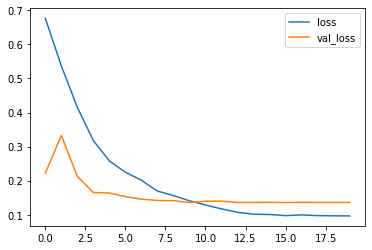

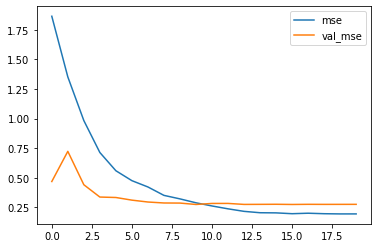

In [15]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['mse', 'val_mse']].plot()

# Submission

In [16]:
model = tf.keras.models.load_model('bag-of-words')

In [17]:
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [18]:
preds_list = []
for index, row in test_df.iterrows():
    preds = model.predict(
        tf.expand_dims(
            bag_vectorization(tf.convert_to_tensor(row['full_text'])), 
            axis=0
        )
    )
    preds = np.clip(preds, 1, 5)
    preds_list.append(preds[0])

In [19]:
sub_df = pd.concat([test_df[['text_id']], pd.DataFrame(preds_list, columns=TARGET_COLS)], axis=1)
sub_df.to_csv('submission.csv', index=False)

In [20]:
sub_df.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,2.703732,2.618363,2.902267,2.678169,2.536679,2.665769
1,000BAD50D026,2.634762,2.533768,2.793166,2.593060,2.460475,2.585933
2,00367BB2546B,3.494394,3.364597,3.544279,3.455393,3.373642,3.413532
